# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Откройте файл с данными и изучите общую информацию. 

In [1]:
# первым шагом импортируем все необходимые библиотеки

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# это поможет легче читать таблицу

pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:2f}'.format

try:
    data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')
except:
    data = pd.read_csv('/Users/ivanivanovich/Desktop/Users/ivanivanovich/Downloads/Яндекс практикум/venv/real_estate_data.csv', sep='\t')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

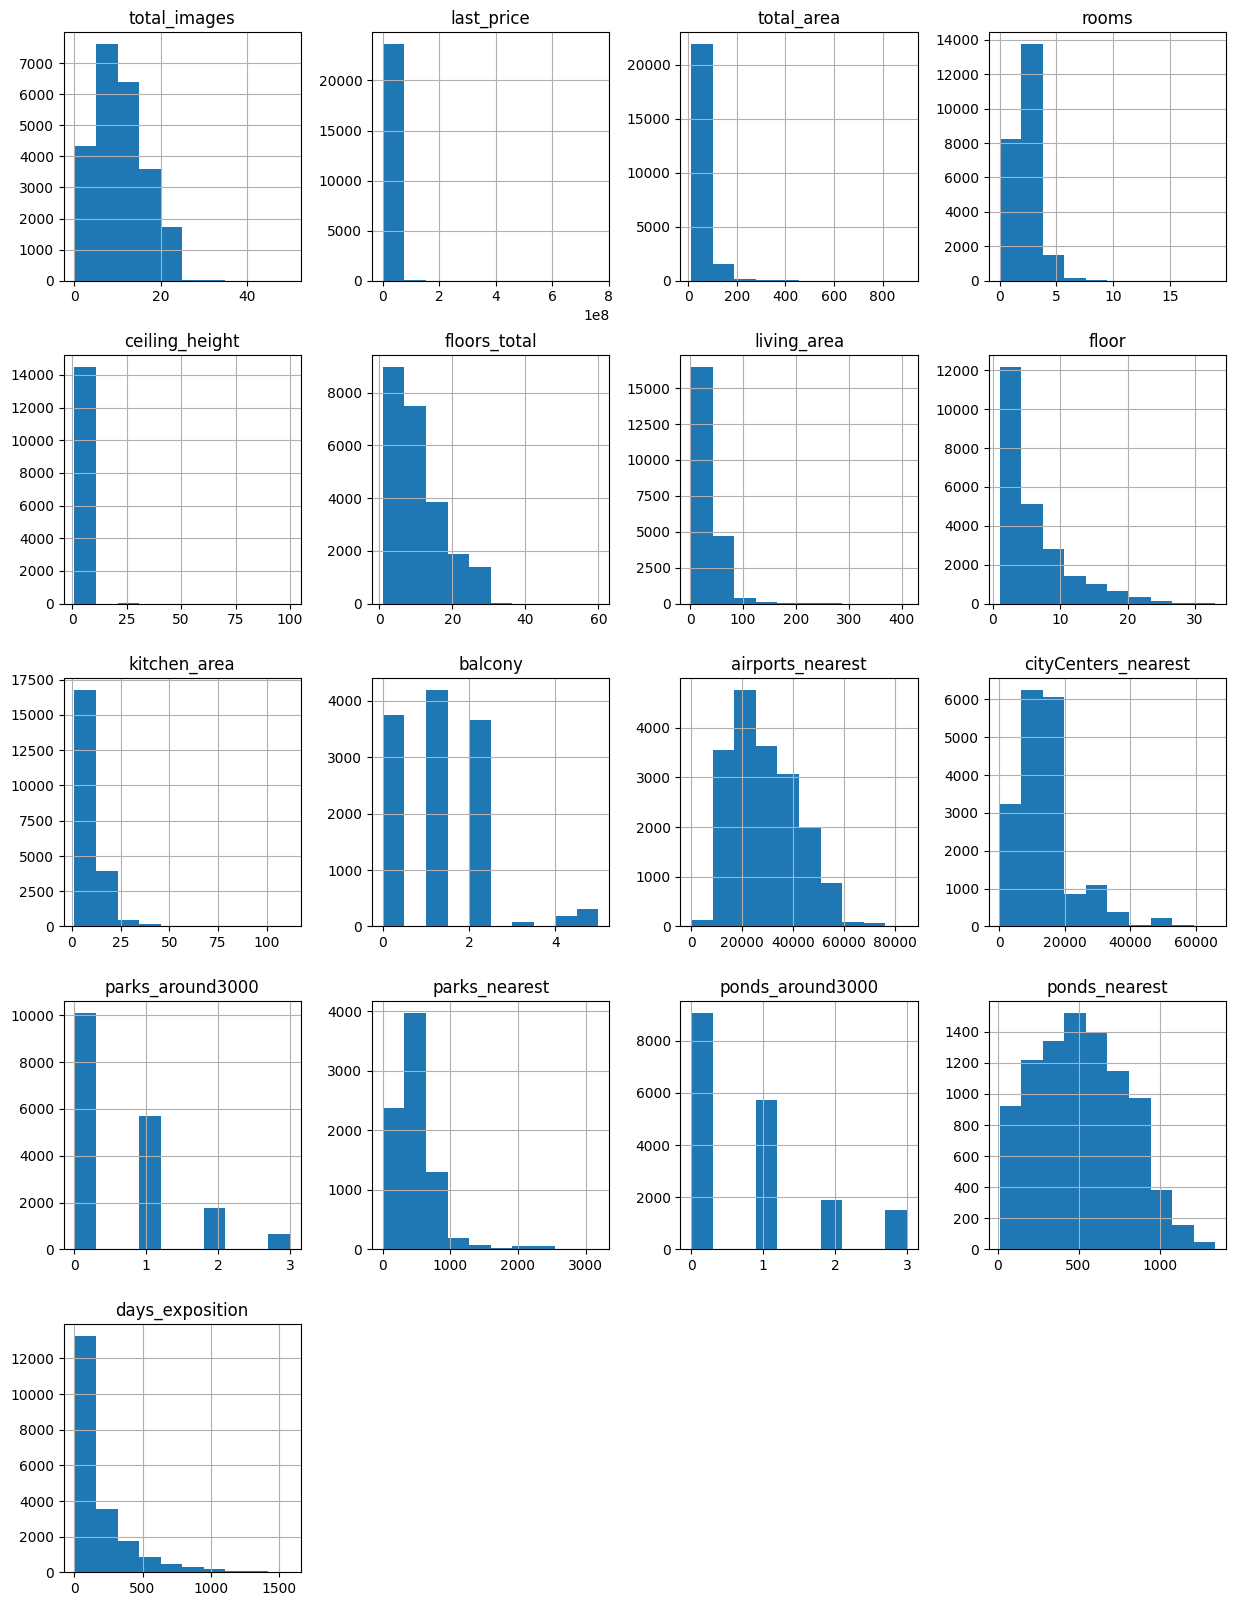

In [3]:
# посмотрим общие сведения о датасете

data.info()
print('--------------------------------------------------------------------------')
print()

# выведим первые 15 строк

print(data.head(15))
print('--------------------------------------------------------------------------')
print()

# построим гистограмму для каждого столбца

data.hist(figsize=(15, 20));

**Вывод**
- И так, у нас внушительный датасет, в котором 23699 строк
- first_day_exposition имеет тип object, логичнее будет datetime64
- balcony имеет тип float64, нужно int64
- is_apartment очень много пропусков, имеет тип object, должен быть bool
- parks_around3000 float64 вместо int64
- ponds_around3000 float64 вместо int64
- days_exposition так же имеет тип float64 вместо int64


### Предобработка данных

**Для начала посмотрим количество пропусков и изменим типы данных**

In [4]:
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

In [5]:
data['last_price'] = data['last_price'].astype('int')

# удалим аномально большие значения

price_to_high = data.loc[(data['last_price'] > 150000000) | (data['last_price'] < 350000)]
data = data.drop(price_to_high.index, axis = 0)

# first_day_exposition меняем тип с object на datetime и убираем значение время для удобства, тк везде проставлено 00:00:00
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%d')

# is_apartment меняем тип с object на bool, пропуски заменяем на False
data['is_apartment'] = data['is_apartment'].fillna(False).astype('bool')

# balcony меняем тип на int пропуски заполняем значением 0
data['balcony'] = data['balcony'].fillna(0).astype('int')

# days_exposition меняем тип на int пропуски заполняем значением 0
data['days_exposition'] = data['days_exposition'].fillna(0).astype('int')

# cityCenters_nearest меняем тип на int пропуски заполняем значением 1 000 000
data['cityCenters_nearest'] = data['cityCenters_nearest'].fillna(1000000)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23683 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23683 non-null  int64         
 1   last_price            23683 non-null  int64         
 2   total_area            23683 non-null  float64       
 3   first_day_exposition  23683 non-null  datetime64[ns]
 4   rooms                 23683 non-null  int64         
 5   ceiling_height        14494 non-null  float64       
 6   floors_total          23597 non-null  float64       
 7   living_area           21781 non-null  float64       
 8   floor                 23683 non-null  int64         
 9   is_apartment          23683 non-null  bool          
 10  studio                23683 non-null  bool          
 11  open_plan             23683 non-null  bool          
 12  kitchen_area          21406 non-null  float64       
 13  balcony         

**Вывод**
- last_price поменял тип на int64, так же удалил значения больше 150млн.
- из first_day_exposition убрал значение времени, тк везде проставлено нулевое, теперь стало легче читать этот столбец
- is_apartment поменял тип данных на bool. Пропущенные значения заменил на False, тут логика следующая: владелец апартоментов точно знает тип своей собственности и заполнит графу корректно, в то время как владелец квартиры, может либо просто не знать, что это, либо пропустить, так как у него не апартаменты
- balcony поменял тип данных на int64, заменил пропуски нулями, вероянее всего логика пропусков как с апартаментами: если балкона нет, то и писать ничего не надо
- days_exposition изменил тип данных на int64, заменил пропуски нулями
- cityCenters_nearest изменил тип данных на int64, первоначально заменил пропуски на 0 но ближе к концу исследования выяснилось, что такое значение искажает данные исследования, в связи с чем было принято решение вместо 0 заменить пропуски на 1 000 000, таким образом с данными стало гораздо легче работать

**Следующим шагом избавимся дубликатов**

In [7]:
print('уникальных наименований:', data['locality_name'].nunique())
print()
# избавимся от дубликатов, переименовав их
data = data.replace({'locality_name' :
    {'городской посёлок Янино-1' : 'городской поселок Янино-1',
     'городской поселок Большая Ижора' : 'поселок городского типа Большая Ижора',
     'городской посёлок Лесогорский' : 'поселок городского типа Лесогорский',
     'городской посёлок Мга': 'посёлок городского типа Мга',
     'городской посёлок Назия' : 'поселок городского типа Назия',
     'городской посёлок Павлово' : 'поселок городского типа Павлово',
     'посёлок городского типа Рощино' : 'поселок городского типа Рощино',
     'городской посёлок Рощино' : 'поселок городского типа Рощино',
     'городской посёлок Советский' : 'поселок городского типа Советский',
     'городской посёлок Фёдоровское' : 'деревня Фёдоровское',
     'поселок Гарболово' : 'деревня Гарболово',
     'поселок Зимитицы' : 'деревня Зимитицы',
     'поселок Калитино' : 'деревня Калитино',
     'поселок Рабитицы' : 'деревня Рабитицы',
     'посёлок Щеглово' : 'деревня Щеглово',
     'посёлок Аннино' : 'поселок Аннино',
     'посёлок Бугры' : 'поселок Бугры',
     'посёлок Возрождение' : 'поселок Возрождение',
     'посёлок Гаврилово' : 'поселок Гаврилово',
     'посёлок станции Громово' : 'поселок Громово',
     'посёлок Жилгородок' : 'поселок Жилгородок',
     'посёлок Ильичёво' : 'поселок Ильичёво',
     'посёлок Кобралово' : 'поселок Кобралово',
     'посёлок Коробицыно' : 'поселок Коробицыно',
     'посёлок Лисий Нос' : 'поселок Лисий Нос',
     'поселок Любань' : 'Любань',
     'посёлок Мельниково' : 'поселок Мельниково',
     'посёлок Мичуринское' : 'поселок Мичуринское',
     'посёлок Мурино' : 'Мурино',
     'поселок Мурино' : 'Мурино',
     'посёлок Новый Свет' : 'поселок Новый Свет',
     'посёлок Пансионат Зелёный Бор' : 'поселок Пансионат Зелёный Бор',
     'посёлок Перово' : 'поселок Перово',
     'посёлок Петровское' : 'поселок Петровское',
     'посёлок Победа' : 'поселок Победа',
     'посёлок Поляны' : 'поселок Поляны',
     'посёлок Тельмана' : 'поселок Тельмана',
     'поселок городского типа Рябово' : 'поселок Рябово',
     'посёлок городского типа Рябово' : 'поселок Рябово',
     'посёлок Старая Малукса' : 'поселок Старая Малукса',
     'посёлок Стеклянный' : 'поселок Стеклянный',
     'посёлок Сумино' : 'поселок Сумино',
     'посёлок Терволово' : 'поселок Терволово',
     'посёлок Усть-Луга' : 'поселок Усть-Луга',
     'посёлок городского типа Вырица' : 'поселок городского типа Вырица',
     'посёлок городского типа Красный Бор' : 'поселок городского типа Красный Бор',
     'посёлок городского типа Кузьмоловский' : 'поселок городского типа Кузьмоловский',
     'посёлок городского типа Лебяжье' : 'поселок городского типа Лебяжье',
     'садовое товарищество Приладожский' : 'поселок городского типа Приладожский',
     'садовое товарищество Рахья' : 'поселок городского типа Рахья',
     'посёлок городского типа Токсово' : 'поселок городского типа Токсово',
     'посёлок городского типа Форносово' : 'поселок городского типа Форносово',
     'посёлок городского типа имени Свердлова' : 'поселок городского типа имени Свердлова',
     'посёлок при железнодорожной станции Вещево' : 'поселок станции Вещево',
     'посёлок при железнодорожной станции Приветнинское' : 'поселок станции Приветнинское'
     ''
}})
    
print('-------------------------')
print()

data = data.dropna(subset=['locality_name'])

print('Осталось уникальных наименований:', data['locality_name'].nunique())
print('--------------------------------')
print()

print('Количество явных дубликатов:', data.duplicated().sum())

уникальных наименований: 364

-------------------------

Осталось уникальных наименований: 310
--------------------------------

Количество явных дубликатов: 0


**Вывод**
- locality_name - было выявлено 54 неявных дубликата, устранил путем переименовывания
- Неявных дубликатов выявлено не было

**выявим аномальные значения и избавимся от них**

In [8]:
print(data.loc[(data['ceiling_height']<2.4) | (data['ceiling_height']>5), 'ceiling_height'].value_counts())
print('--------------------------------------------------------------------------')

print('Аномальных данных:', data.loc[(data['ceiling_height']<2.4) | (data['ceiling_height']>5), 'ceiling_height'].value_counts().sum())

ceiling_height_abnormal = data.loc[(data['ceiling_height']<2.4) | (data['ceiling_height']>5), 'ceiling_height']
data = data.drop(ceiling_height_abnormal.index, axis = 0)

# тк в срез будут попадать населенные пункты с одним или чуть более объявлений, где содержаться только пропуски,
# подставить туда медианное значение не получится, в результате чего при выводе мы получим сообщение об ошибке,
# чтобы результат читался проще, проигнорируем вывод сообщения об ошибке

import warnings

warnings.simplefilter("ignore", category=RuntimeWarning)

# посчитаем медианное значение высоты потолков

for x in data['locality_name'].unique():
    data.loc[(data['locality_name'] == x) & (data['ceiling_height'].isna()), 'ceiling_height'] = \
    data.loc[(data['locality_name'] == x), 'ceiling_height'].median()

# удаляем оставшиеся пропущеные значения

data = data.dropna(subset=['ceiling_height'])
print('--------------------------------------------------------------------------')
print()

2.000000      11
27.000000      8
25.000000      7
2.300000       4
8.000000       3
32.000000      2
2.340000       1
1.750000       1
1.000000       1
10.300000      1
27.500000      1
5.800000       1
22.600000      1
6.000000       1
2.250000       1
20.000000      1
5.500000       1
14.000000      1
2.200000       1
5.300000       1
8.300000       1
1.200000       1
26.000000      1
24.000000      1
5.600000       1
5.200000       1
100.000000     1
Name: ceiling_height, dtype: int64
--------------------------------------------------------------------------
Аномальных данных: 56
--------------------------------------------------------------------------



In [9]:
# посмотрим количество квартир

data['rooms'].value_counts()

1     7991
2     7852
3     5764
4     1171
5      322
0      193
6      101
7       57
8       11
9        8
10       3
11       2
14       2
15       1
19       1
16       1
Name: rooms, dtype: int64

In [10]:
# избавимся от дворцов

rooms_to_match = data.loc[data['rooms'] > 6]
data = data.drop(rooms_to_match.index, axis = 0)

In [11]:
pd.DataFrame(round(data.isna().mean()*100,)).style.background_gradient('coolwarm')

,0
total_images,0.000000
last_price,0.000000
total_area,0.000000
first_day_exposition,0.000000
rooms,0.000000
ceiling_height,0.000000
floors_total,0.000000
living_area,8.000000
floor,0.000000
is_apartment,0.000000


In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23394 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23394 non-null  int64         
 1   last_price            23394 non-null  int64         
 2   total_area            23394 non-null  float64       
 3   first_day_exposition  23394 non-null  datetime64[ns]
 4   rooms                 23394 non-null  int64         
 5   ceiling_height        23394 non-null  float64       
 6   floors_total          23309 non-null  float64       
 7   living_area           21531 non-null  float64       
 8   floor                 23394 non-null  int64         
 9   is_apartment          23394 non-null  bool          
 10  studio                23394 non-null  bool          
 11  open_plan             23394 non-null  bool          
 12  kitchen_area          21174 non-null  float64       
 13  balcony         

**Вывод**
- ceiling_height Присутствовали нереалистичные данные, например высота потолков 1 метр или же 100. Так же были данные вроде 25, 27, 35 метров, допускаю, что это просто ошибка ввода данных, так пользователь просто неккоректоно указал формат числа и вместо 2.5 ввел 25. Принял решение удалить строки со значением ниже 2.5 метров (тк в жилых помещениях потолки ниже не предусмотрены) и выше 5 метров. Всего таких строк нашлось 57, их удаление поможет установить более точное среднее и медианное значение высоты, но и не должно сказаться на исследовании
- пропущенных значений 9195, очень много, практически треть. Заполнил с помощью цикла, записав медианное значение для каждого населенного пункта. При таком способе осталось всего 95 пропусков, вероятно - это населенные пункты по которым 1 - 2 квартиры и в тех отсутствуют данные, потому и не удалось их заполнить. Так же удалил
- floors_total - 85 пропущенных значений. Причина пропусков неясна, скорее всего просто забыли указать. Пока оставлю
- Предположение. Можно попробовать заполнить их значением из колонки floor допустив, что это верхний этаж.
- rooms избавился от квартир где больше 6 комнат
- cityCenters_nearest - 5519 пропущенных значений, принял решение заменить на 0 и учесть это при анализе.

### Посчитайте и добавьте в таблицу новые столбцы

In [13]:
# считаем цену кв.м.

data['square_meter_price'] = data['last_price'] / data['total_area']

# создаем день недели, месяц, год публикации объявления

data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'])
data['weekday'] = data['first_day_exposition'].dt.weekday
data['month'] = data['first_day_exposition'].dt.month
data['year'] = data['first_day_exposition'].dt.year

#сортируем квартиры по этажам

def categorize_floors(row):
    floors_total = row['floors_total']
    floor = row['floor']
    try:
        if floor == 1:
            return 'первый'
        elif floor == floors_total:
            return 'последний'
        elif 1 < floor < floors_total:
            return 'другой'
    except:
        pass

data['floor_type'] = data.apply(categorize_floors, axis = 1)    

# переводим метры в километры

data['cityCenters_nearest'] = data['cityCenters_nearest'] / 1000
data['cityCenters_nearest'] = data['cityCenters_nearest'].round().astype('int')

- total_area                  0
- rooms                       0
- ceiling_height              0
- floors_total               85
- living_area              1871
- floor                       0
- studio                      0
- open_plan                   0
- kitchen_area             2231

### Проведите исследовательский анализ данных

#### изучите следующие параметры объектов

цена на момент снятия с публикации:
4500000     342
3500000     288
4000000     259
4300000     259
4200000     257
           ... 
29375000      1
7545600       1
42000000      1
5205000       1
11475000      1
Name: last_price, Length: 2922, dtype: int64
count       23394.000000
mean      6276616.516756
std       7029075.174611
min        430000.000000
25%       3450000.000000
50%       4650000.000000
75%       6750000.000000
max     150000000.000000
Name: last_price, dtype: float64


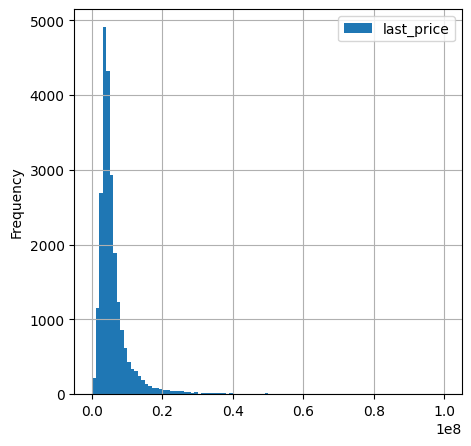

---------------------------------------------

этаж:
2     3299
3     3025
1     2863
4     2769
5     2576
6     1296
7     1202
8     1079
9     1047
10     686
12     524
11     522
13     378
15     341
14     333
16     315
17     225
18     177
19     146
21     123
22     112
20     110
23      99
24      63
25      44
26      24
27      10
28       1
30       1
29       1
32       1
33       1
31       1
Name: floor, dtype: int64


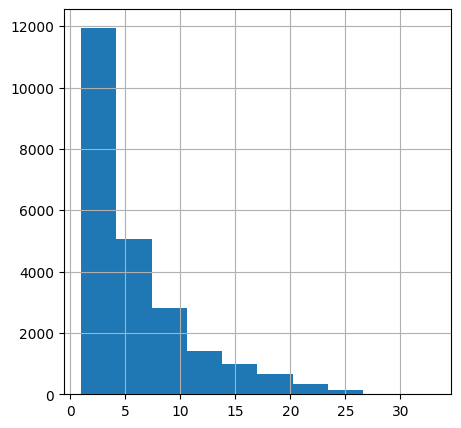

---------------------------------------------

расстояние до центра города:
1000    5391
12      1602
15      1566
13      1455
14      1276
        ... 
62         1
59         1
45         1
61         1
63         1
Name: cityCenters_nearest, Length: 62, dtype: int64
count   23394.000000
mean      241.400915
std       415.198274
min         0.000000
25%        11.000000
50%        15.000000
75%        35.000000
max      1000.000000
Name: cityCenters_nearest, dtype: float64


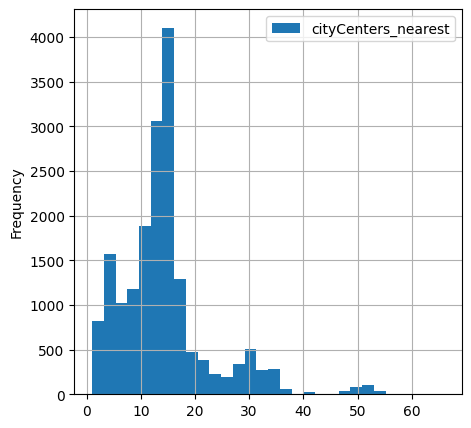

---------------------------------------------

расстояние до ближайшего аэропорта:
37434.000000    61
21928.000000    32
44870.000000    30
39946.000000    30
37407.000000    27
                ..
36477.000000     1
18797.000000     1
24902.000000     1
21280.000000     1
24665.000000     1
Name: airports_nearest, Length: 8195, dtype: int64


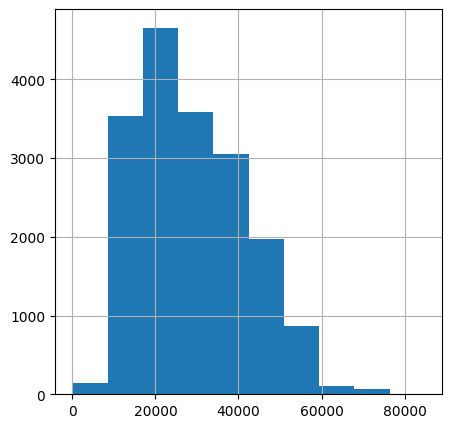

---------------------------------------------

расстояние до ближайшего парка:
441.000000     67
392.000000     41
456.000000     40
173.000000     40
471.000000     31
               ..
2348.000000     1
859.000000      1
1150.000000     1
321.000000      1
2984.000000     1
Name: parks_nearest, Length: 992, dtype: int64


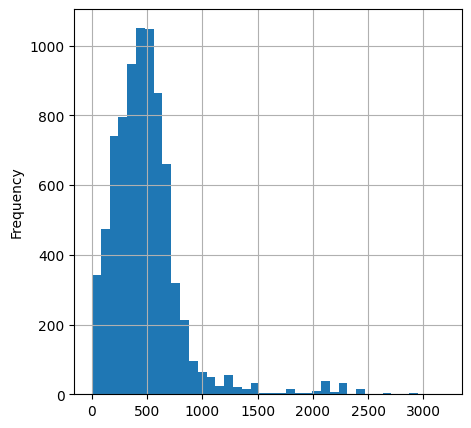

---------------------------------------------

месяц публикации
2     2609
3     2542
4     2349
11    2343
10    2104
9     1962
6     1733
8     1726
7     1666
12    1617
1     1481
5     1262
Name: month, dtype: int64


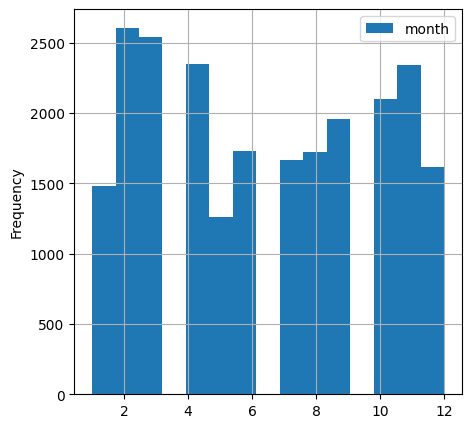

0         3
1        12
2         8
3         7
4         6
         ..
23693     8
23694     3
23695     1
23697     3
23698     7
Name: month, Length: 23394, dtype: int64


In [14]:
print('цена на момент снятия с публикации:')
print(data['last_price'].value_counts())
print(data['last_price'].describe())
data.plot(y = 'last_price', kind = 'hist', bins = 100, range = (12190, 100000000), grid = True, figsize = (5, 5))
plt.show()
print('---------------------------------------------')
print()

print('этаж:')
print(data['floor'].value_counts())
data['floor'].hist(figsize=(5, 5))
plt.show()
print('---------------------------------------------')
print()

print('расстояние до центра города:')
print(data['cityCenters_nearest'].value_counts())
print(data['cityCenters_nearest'].describe())
data.plot(y = 'cityCenters_nearest', kind = 'hist', bins = 30, range =(1, 66), grid=True, figsize = (5, 5))
plt.show()
print('---------------------------------------------')
print()

print('расстояние до ближайшего аэропорта:')
print(data['airports_nearest'].value_counts())
data['airports_nearest'].hist(figsize=(5, 5))
plt.show()
print('---------------------------------------------')
print()

print('расстояние до ближайшего парка:')
print(data['parks_nearest'].value_counts())
data['parks_nearest'].plot(y = 'parks_nearest', kind = 'hist', bins = 40, grid=True, figsize = (5, 5))
plt.show()
print('---------------------------------------------')
print()

print('месяц публикации')
print(data['month'].value_counts())
data.plot(y = 'month', kind = 'hist', bins = 15, grid=True, figsize = (5, 5))
plt.show()

print(data['month'])

общая площадь квартиры:
45.000000     414
42.000000     379
31.000000     345
60.000000     344
44.000000     341
             ... 
58.710000       1
60.750000       1
63.190000       1
237.000000      1
76.750000       1
Name: total_area, Length: 2116, dtype: int64
Среднее значение: 59.41169872616911


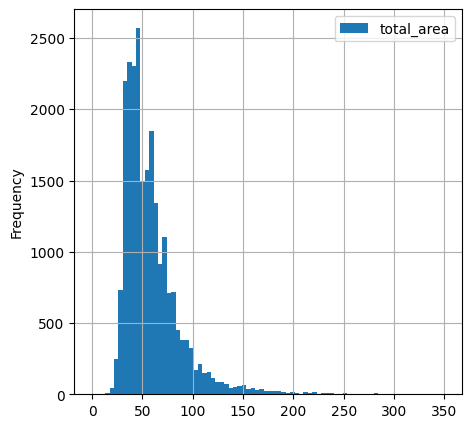

In [15]:
print('общая площадь квартиры:')
print(data['total_area'].value_counts())
print('Среднее значение:', data['total_area'].mean())
data.plot(y = 'total_area', kind = 'hist', bins = 80, range =(0, 350),  grid = True, figsize = (5, 5))
plt.show()

- total_area - больше всего значений в диапазоне от 31 до 60кв.м. Среднее значение - 59.5

жилая площадь:
18.000000    878
17.000000    668
30.000000    589
16.000000    484
20.000000    476
            ... 
68.480000      1
31.120000      1
43.450000      1
30.310000      1
42.550000      1
Name: living_area, Length: 1730, dtype: int64


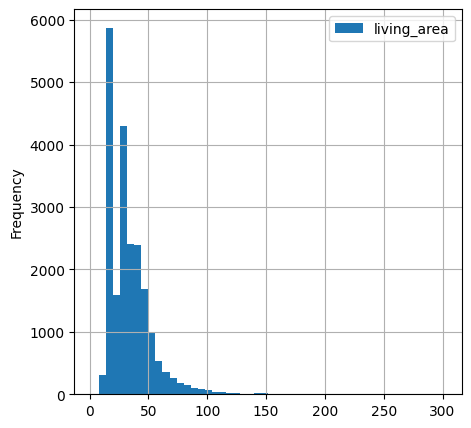

In [16]:
print('жилая площадь:')
print(data['living_area'].value_counts())
data.plot(y = 'living_area', kind = 'hist', bins = 50,  grid = True, figsize = (5, 5))
plt.show()

- living_area - есть два пика 17 и 18м и в районе 25 -30кв.м.- это самые распространенные метражи

площадь кухни:
6.000000     1289
10.000000    1252
8.000000     1102
9.000000     1085
7.000000     1055
             ... 
11.840000       1
13.270000       1
13.170000       1
6.830000        1
13.830000       1
Name: kitchen_area, Length: 959, dtype: int64


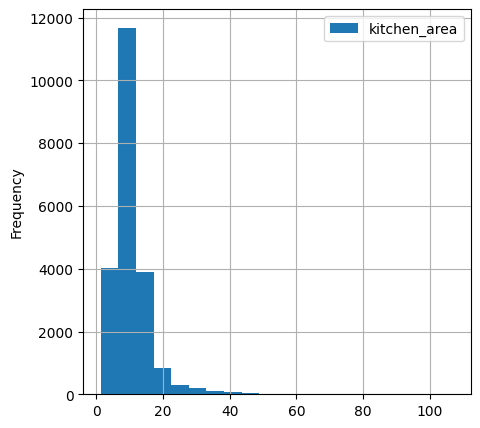

In [17]:
print('площадь кухни:')
print(data['kitchen_area'].value_counts())
data.plot(y = 'kitchen_area', kind = 'hist', bins = 20,  grid = True, figsize = (5, 5))
plt.show()

- kitchen_area - кухни со средней площадью 10 кв.м. самые распространенные

число комнат:
1    7991
2    7852
3    5764
4    1171
5     322
0     193
6     101
Name: rooms, dtype: int64


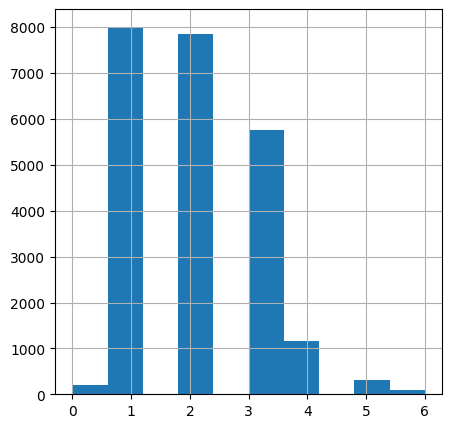

In [18]:
print('число комнат:')
print(data['rooms'].value_counts())
data['rooms'].hist(figsize=(5, 5))
plt.show()

- rooms присутствуют данные с нулевым значением - видимо это студии,больше всего однакомнатных квартир и двухкомнатных квартир

высота потолков:
2.700000    7808
2.500000    4161
2.600000    2137
2.550000    1604
2.750000    1112
            ... 
3.840000       1
4.060000       1
4.150000       1
5.000000       1
3.590000       1
Name: ceiling_height, Length: 162, dtype: int64


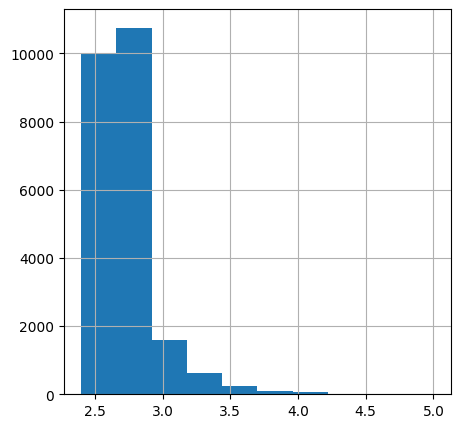

In [19]:
print('высота потолков:')
print(data['ceiling_height'].value_counts())
data['ceiling_height'].hist(figsize=(5, 5))
plt.show()

- ceiling_height самой распространенной высотой потолков оказалось 2.7м.

тип этажа:
другой       17197
последний     3252
первый        2863
Name: floor_type, dtype: int64


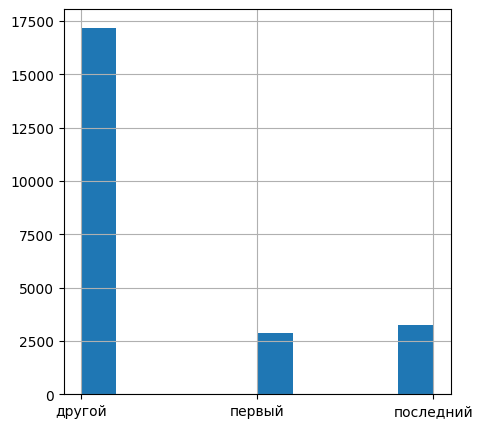

In [20]:
print('тип этажа:')
print(data['floor_type'].value_counts())
data['floor_type'].hist(figsize=(5, 5))
plt.show()

- floor_type - ожидаемо, самой большой категорией оказалась "другой" так как туда входят все этажи кроме первого и последнего, ничего удивительного

всего этажей:
5.000000     5679
9.000000     3751
16.000000    1371
12.000000    1359
10.000000    1172
4.000000     1167
25.000000    1072
6.000000      884
17.000000     830
3.000000      643
7.000000      574
14.000000     551
18.000000     503
24.000000     461
8.000000      383
15.000000     364
2.000000      350
23.000000     349
19.000000     339
22.000000     286
20.000000     270
13.000000     229
11.000000     202
27.000000     164
21.000000     158
26.000000     124
35.000000      24
1.000000       22
28.000000      21
36.000000       2
34.000000       1
60.000000       1
29.000000       1
33.000000       1
52.000000       1
Name: floors_total, dtype: int64


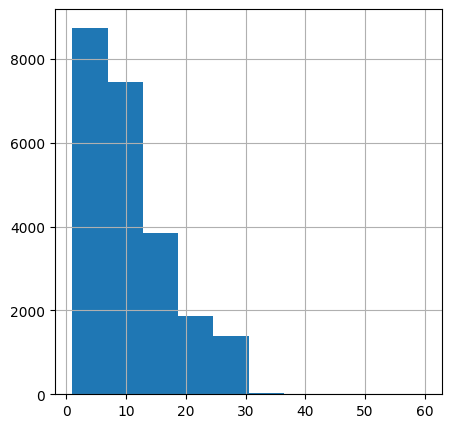

In [21]:
print('всего этажей:')
print(data['floors_total'].value_counts())
data['floors_total'].hist(figsize=(5, 5))
plt.show()

- floors_total - самые распространенные - пятиэтажки

день публикации
3    4232
1    4137
4    3956
2    3920
0    3565
5    1909
6    1675
Name: weekday, dtype: int64


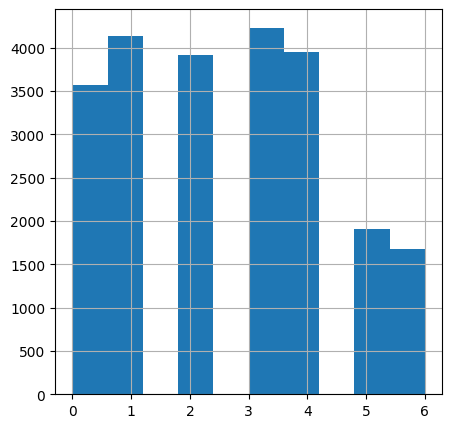

In [22]:
print('день публикации')
print(data['weekday'].value_counts())
data['weekday'].hist(figsize=(5, 5))
plt.show()

- weekday чаще всего объявления публикуют по четвергам и вторникам, реже всего по воскресеньям

#### Изучите как быстро продавались квартиры

count   20280.000000
mean      180.694625
std       219.740142
min         1.000000
25%        45.000000
50%        95.000000
75%       231.000000
max      1580.000000
Name: days_exposition, dtype: float64


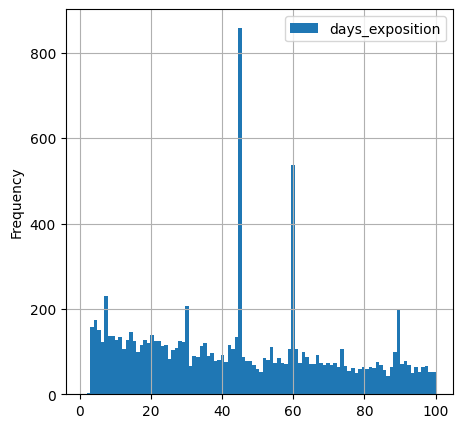

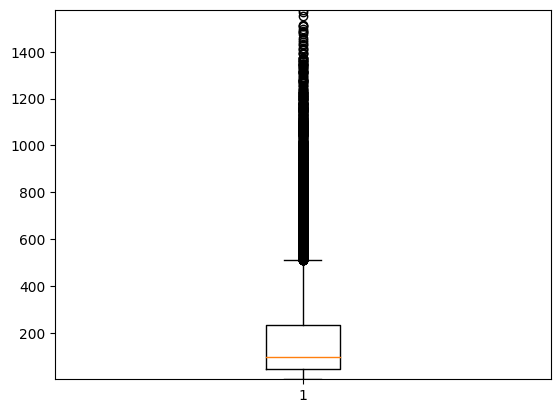

In [23]:
# посмотрим среднее и медиану без нулевых значений
print(data[data['days_exposition'] != 0]['days_exposition'].describe())

# построим гистаграмму
data.plot(y = 'days_exposition', kind = 'hist', bins = 100, range =(1, 100), grid=True, figsize = (5, 5))
plt.show()

plt.ylim(1, 1580)
plt.boxplot(data[data['days_exposition'] != 0]['days_exposition'])
plt.show()

Вывод
- диаграмма имеет два особо больших пика - 45 и 59 день
- среднее значение размещений - 180 дней, медиана - 95, первый квартиль - 45, третий - 231
- стандартное октлонение 219.7, что говорит об очень большом разбросе
- диаграмма размаха показывает значения от 1 до примерно 500, в этом диапазоне находятся верные значения, за их пределами - выбросы. 
- Получается, что быстрых объвлений нет, а необычайно долгие - свыше 500 дней

#### Какие факторы больше всего влияют на общую (полную) стоимость объекта?

Создадим сводные таблицы и построим графики

0.741070433885789


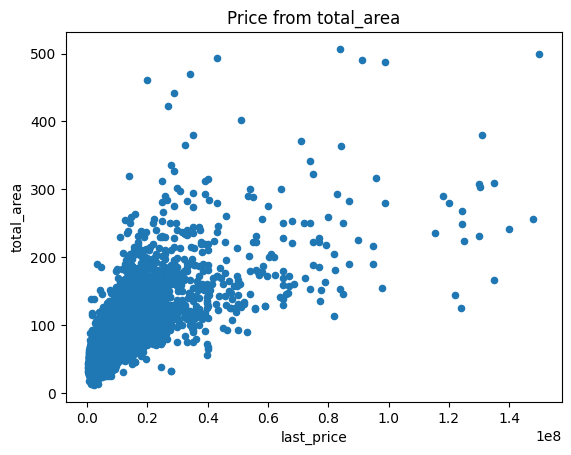

In [24]:
pivot = data.pivot_table(index = 'total_area', values = 'last_price', aggfunc = ['mean', 'count', 'median']).reset_index()
pivot.columns = ['total_area', 'mean', 'count', 'median']
#display(pivot.sort_values('median', ascending = False))

data.plot(kind = 'scatter', y = 'total_area', x = 'last_price', title = 'Price from ' + 'total_area')
print(data['total_area'].corr(data['last_price']))
plt.show()

**Вывод**
- Корреляция Пирсона - 0.7 - довльно большая, что свидетельствует о связи цены и площади, с ростом площади растет и цена

0.649711641785926


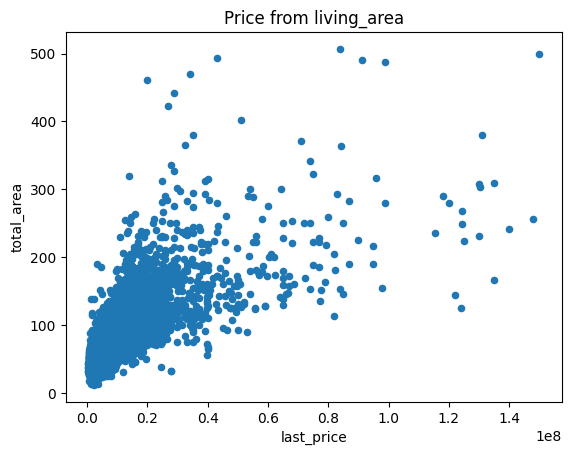

In [25]:
pivot = data.pivot_table(index = 'living_area', values = 'last_price', aggfunc = ['mean', 'count', 'median']).reset_index()
pivot.columns = ['living_area', 'mean', 'count', 'median']
#display(pivot.sort_values('median', ascending = False))

data.plot(kind = 'scatter', y = 'total_area', x = 'last_price', title = 'Price from ' + 'living_area')
print(data['living_area'].corr(data['last_price']))
plt.show()

**Вывод**
- Корреляция Пирсона чуть меньше - 0.6 но тенденция прослеживается та - же, увеличение площади, влечет увеличение цены

0.5753915412469405


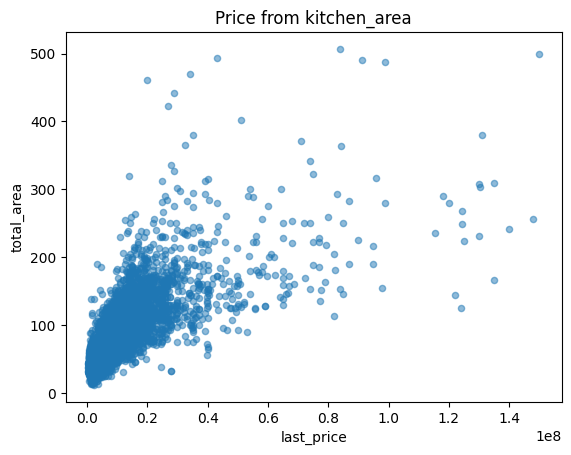

In [26]:
pivot = data.pivot_table(index = 'kitchen_area', values = 'last_price', aggfunc = ['mean', 'count', 'median']).reset_index()
pivot.columns = ['kitchen_area', 'mean', 'count', 'median']
#display(pivot.sort_values('median', ascending = False))

data.plot(kind = 'scatter', y = 'total_area', x = 'last_price', title = 'Price from ' + 'kitchen_area', alpha = 0.5)
print(data['kitchen_area'].corr(data['last_price']))
plt.show()

**Вывод**
- Аналогично выводам выше. В целом можно сделать вывод: цена напрямую зависит от площади, так увеличение любой площади (общей, жилой, либо отдельного помещения) влечет за собой и рост цены

0.42123820490735325


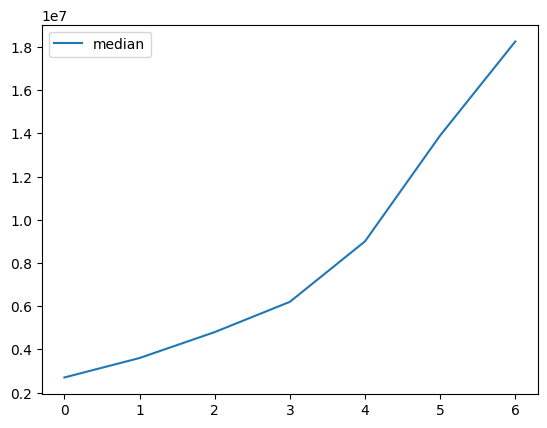

In [27]:
pivot = data.pivot_table(index = 'rooms', values = 'last_price', aggfunc = ['mean', 'count', 'median']).reset_index()
pivot.columns = ['rooms', 'mean', 'count', 'median']
#display(pivot.sort_values('median', ascending = False))

pivot.plot(y = 'median')
print(data['rooms'].corr(data['last_price']))
plt.show()

**Вывод**
- с увеличением числа комнат, постепенно увеличивается и цена, есть скачок в росте после трехкомнатных квартир и четырехкамнатныхкомнатных

,weekday,mean,count,median
1,1,6214322.699057,4137,4709190
2,2,6238346.016837,3920,4700000
0,0,6148768.130715,3565,4650000
3,3,6564178.804584,4232,4650000
4,4,6282610.134985,3956,4590000
5,5,6109026.535359,1909,4560000
6,6,6242445.948657,1675,4550000


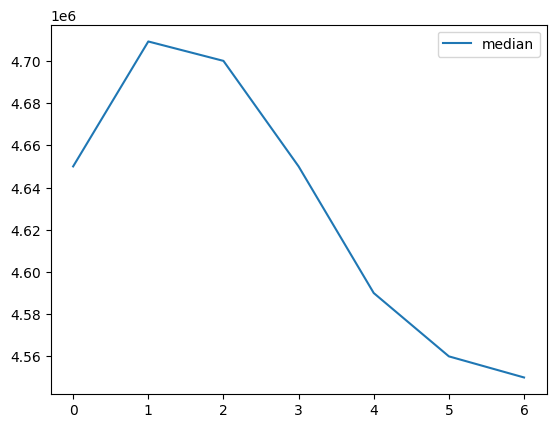

In [28]:
pivot = data.pivot_table(index = 'weekday', values = 'last_price', aggfunc = ['mean', 'count', 'median']).reset_index()
pivot.columns = ['weekday', 'mean', 'count', 'median']
display(pivot.sort_values('median', ascending = False))

pivot.plot(y = 'median')
plt.show()

**Вывод**
- по гистограмме по дням недели видно, что по вторникам публикуются самые дорогие объявления, самые дешевые в воскресенье

,month,mean,count,median
3,4,6239722.920392,2349,4800000
8,9,6365659.864424,1962,4700000
10,11,6300179.701238,2343,4700000
11,12,6560061.536178,1617,4700000
2,3,6034751.862707,2542,4690000
1,2,6283077.092756,2609,4650000
0,1,6488595.332883,1481,4600000
6,7,6454513.708283,1666,4600000
7,8,6251971.208575,1726,4580000
9,10,5984074.267586,2104,4560000


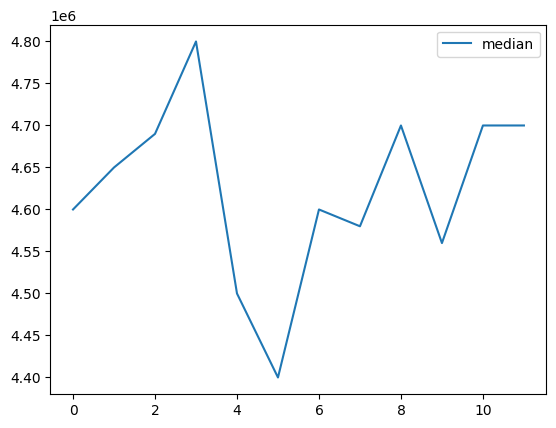

In [29]:
pivot = data.pivot_table(index = 'month', values = 'last_price', aggfunc = ['mean', 'count', 'median']).reset_index()
pivot.columns = ['month', 'mean', 'count', 'median']
display(pivot.sort_values('median', ascending = False))

pivot.plot(y = 'median')
plt.show()

**Вывод**
- по месяцам из гистограммы видно, что начиная с января цена начинает расти и на март приходятся самые дорогие объявления,после чего начинается резкое падение которое приходится на май - тут самая низкая цена, после чего начинается рост

,year,mean,count,median
0,2014,12046600.176471,136,7640000
1,2015,8191269.836348,1161,5300000
5,2019,6495323.185277,2839,5050000
4,2018,5854541.182304,8420,4590000
2,2016,6581477.602989,2743,4530000
3,2017,6164090.493638,8095,4500000


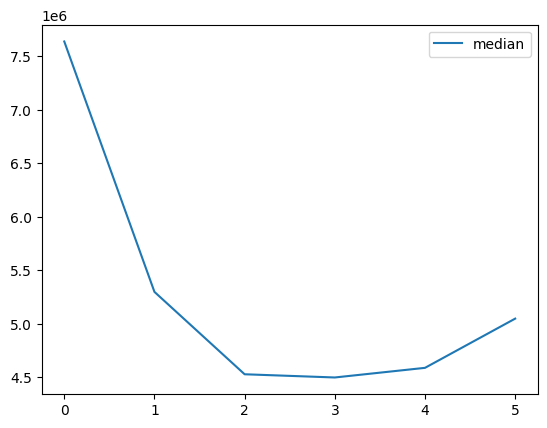

In [30]:
pivot = data.pivot_table(index = 'year', values = 'last_price', aggfunc = ['mean', 'count', 'median']).reset_index()
pivot.columns = ['year', 'mean', 'count', 'median']
display(pivot.sort_values('median', ascending = False))

pivot.plot(y = 'median')
plt.show()

**Вывод**
- по годам видно резкое падение стоимости начиная с 2014 года, которое выровнялось в 2016, а начиная с 2018 начался рост

,mean,count,median
floor_type,,,
другой,6519162.063558,17197,4838050
последний,6336364.241697,3252,4300000
первый,4731498.451275,2863,3900000


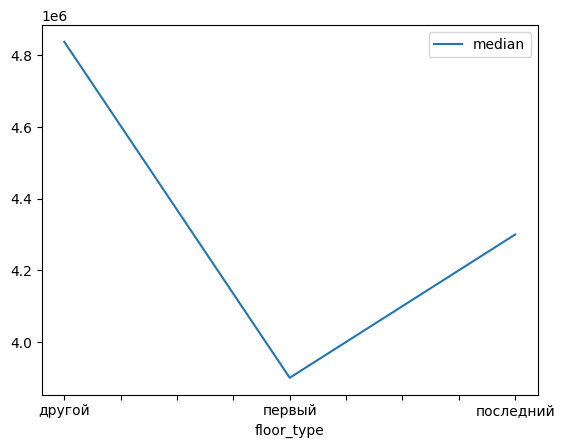

In [31]:
floor_type_pivot = data.pivot_table(index = 'floor_type', values = 'last_price', aggfunc = ['mean', 'count', 'median'])
floor_type_pivot.columns = ['mean', 'count', 'median']
display(floor_type_pivot.sort_values('median', ascending = False))
floor_type_pivot.plot(y = 'median')

plt.show()


**Вывод**
- по этажам - ожидаемо первый этаж оказался самым дешевым, неожиданно, но средние этажи оказались самыми дорогими(хотя я предполагал, что самым дорогим будет последний этаж)

#### Посчитайте среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений. Выделите населённые пункты с самой высокой и низкой стоимостью квадратного метра.

In [32]:
# создадим сводную таблицу, с наименованиями населённых пунктов и ценой за кв.м. посчитаем кол-во и среднее значение
pivot_top = data.pivot_table(
    index = 'locality_name',
    values = 'square_meter_price',
    aggfunc = ['count', 'mean']
)

# дадим название столбцам
pivot_top.columns = ['count', 'mean']

# отсортируем по количеству объявлений
pivot_top = pivot_top.sort_values('count', ascending = False).head(10)
print(pivot_top)
print('-----------------------------------------')
print()

print('Самая высокая стоимость', pivot_top[pivot_top['mean'] == pivot_top['mean'].max()])
print('-----------------------------------------')
print()
print('Самая низкая стоимость', pivot_top[pivot_top['mean'] == pivot_top['mean'].min()])

                   count          mean
locality_name                         
Санкт-Петербург    15594 114016.897417
Мурино               588  86064.821204
посёлок Шушары       440  78677.364217
Всеволожск           397  68719.320400
Пушкин               368 103100.890905
Колпино              337  75333.295801
посёлок Парголово    326  90332.263023
Гатчина              306  68757.678644
деревня Кудрово      299  92473.547576
Выборг               235  58238.143141
-----------------------------------------

Самая высокая стоимость                  count          mean
locality_name                       
Санкт-Петербург  15594 114016.897417
-----------------------------------------

Самая низкая стоимость                count         mean
locality_name                    
Выборг           235 58238.143141


**Вывод**
- Из 10 населенных пунктов с наибольшим количеством объявлений:
- Самая высокая стоимость - Санкт-Петербург - 114016.8
- Самая низкая стоимость - Выборг - 58238.1

#### Ранее вы посчитали расстояние до центра в километрах. Теперь выделите квартиры в Санкт-Петербурге с помощью столбца locality_name и вычислите среднюю цену каждого километра. Опишите, как стоимость объектов зависит от расстояния до центра города.

                     square_meter_price
cityCenters_nearest                    
0                         233483.118695
1                         159025.942621
2                         154509.304327
3                         121271.359477
4                         130357.952766
5                         138892.207003
6                         148803.410689
7                         155886.285453
8                         124331.052035
9                         113321.952734
10                        112901.034113
11                        108655.307546
12                        107507.955826
13                        108162.955368
14                        104260.478970
15                        104261.625681
16                        100567.059959
17                         96564.826617
18                         96362.263941
19                         98652.736027
20                        103081.679025
21                         94469.584582
22                         91330.425050


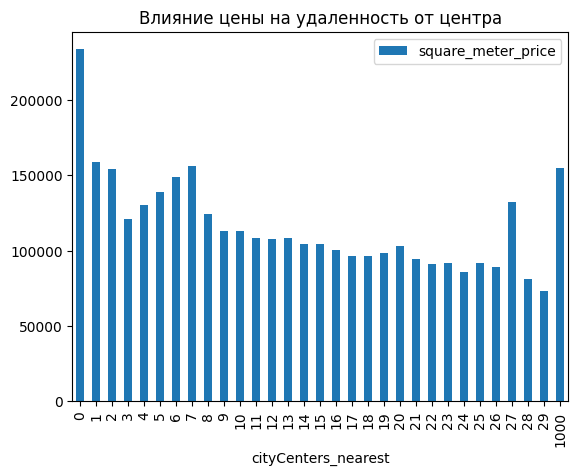

In [33]:
pivot_loc = data.loc[(data['locality_name'] == 'Санкт-Петербург') & (
    data['cityCenters_nearest'] != 1000000)].pivot_table(
    index = 'cityCenters_nearest', values = 'square_meter_price'
)
print(pivot_loc)

pivot_loc.plot(y = 'square_meter_price', kind = 'bar', title = 'Влияние цены на удаленность от центра')
plt.show()

                                              

**Вывод**
- по диаграмме и данным видно, что самая дорогая недвижимость находится непосредственно в центре, а по удалению от центра, цена за квадратный метр падает, на 27 км заметен значительный рост, судя по всему это г. Сестрорецк, который является курортной зоной отсюда и рост цен. Так как Сестрорецк является частью Ленинградской области нет смысла учитывать его.

### Общий вывод
- В этом исследовании мы изучили данные о продаже недвижимости и влиянии различных факторов на ее стоимость
- в ходе исследования пришлось выявить пропущенные значения, частично установить причины этих пропусков и там где возможно заполнить их, изменить тип данных в столбцах, где это был необходимо, устранить неявные дубликаты в названиях населенных пунктов, расчитать стоимость квадратного метра и категоризировать этажи по типам
- В ходе исследования пришел к неочевидным выводам:
- цена средних этажей - выше чем у последнего
- по вторникам публикуются самые дорогостоящие объявления
- стоимость связана с месяцем публикации

- из очевидного:
- самая дешевая недвижимость находится на первом этаже
- чем дальше от центра - тем ниже цена за квадратный метр
- чем больше площадь, тем больше цена
- чем больше комнат, тем больше цена

**Чек-лист готовности проекта**

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  открыт файл
- [x]  файлы изучены (выведены первые строки, метод `info()`, гистограммы и т.д.)
- [x]  определены пропущенные значения
- [x]  заполнены пропущенные значения там, где это возможно
- [x]  есть пояснение, какие пропущенные значения обнаружены
- [x]  изменены типы данных
- [x]  есть пояснение, в каких столбцах изменены типы и почему
- [x]  устранены неявные дубликаты в названиях населённых пунктов
- [x]  устранены редкие и выбивающиеся значения (аномалии) во всех столбцах
- [x]  посчитано и добавлено в таблицу: цена одного квадратного метра
- [x]  посчитано и добавлено в таблицу: день публикации объявления (0 - понедельник, 1 - вторник и т.д.)
- [x]  посчитано и добавлено в таблицу: месяц публикации объявления
- [x]  посчитано и добавлено в таблицу: год публикации объявления
- [x]  посчитано и добавлено в таблицу: тип этажа квартиры (значения — «первый», «последний», «другой»)
- [x]  посчитано и добавлено в таблицу: расстояние в км до центра города
- [x]  изучены и описаны следующие параметры:
        - общая площадь;
        - жилая площадь;
        - площадь кухни;
        - цена объекта;
        - количество комнат;
        - высота потолков;
        - этаж квартиры;
        - тип этажа квартиры («первый», «последний», «другой»);
        - общее количество этажей в доме;
        - расстояние до центра города в метрах;
        - расстояние до ближайшего аэропорта;
        - расстояние до ближайшего парка;
        - день и месяц публикации объявления
- [x]  построены гистограммы для каждого параметра
- [x]  выполнено задание: "Изучите, как быстро продавались квартиры (столбец days_exposition). Этот параметр показывает, сколько дней «висело» каждое объявление.
    - Постройте гистограмму.
    - Посчитайте среднее и медиану.
    - В ячейке типа markdown опишите, сколько обычно занимает продажа. Какие продажи можно считать быстрыми, а какие — необычно долгими?"
- [x]  выполнено задание: "Какие факторы больше всего влияют на общую (полную) стоимость объекта? Постройте графики, которые покажут зависимость цены от указанных ниже параметров. Для подготовки данных перед визуализацией вы можете использовать сводные таблицы."
        - общей площади;
        - жилой площади;
        - площади кухни;
        - количество комнат;
        - типа этажа, на котором расположена квартира (первый, последний, другой);
        - даты размещения (день недели, месяц, год);
- [x]  выполнено задание: "Посчитайте среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений. Выделите населённые пункты с самой высокой и низкой стоимостью квадратного метра. Эти данные можно найти по имени в столбце `locality_name`."
- [x]  выполнено задание: "Ранее вы посчитали расстояние до центра в километрах. Теперь выделите квартиры в Санкт-Петербурге с помощью столбца `locality_name` и вычислите среднюю цену каждого километра. Опишите, как стоимость объектов зависит от расстояния до центра города."
- [x]  в каждом этапе есть промежуточные выводы
- [x]  есть общий вывод